In [1]:
import tensorflow as tf
from tensorflow import keras    
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras import layers, models
from modules import utils, CallBacks, History, PreTrain
from tensorflow.keras import Model
import pickle
import seaborn as sns
import time
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas as pd

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
image_size = 150
batch_size = 64
epochs = 50

In [5]:
data_folder = 'data\data2'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f"{data_folder}",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size,
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names = dataset.class_names
num_classes = len(class_names)
class_names

['Pepper_bell_Bacterial_spot',
 'Pepper_bell_healthy',
 'Potato_Early_blight',
 'Potato_Late_blight',
 'Potato_healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Tomato_YellowLeaf_Curl_Virus',
 'Tomato_Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
class_dis = [len(os.listdir(f'{data_folder}\{name}')) for name in class_names]
class_dis

[997,
 1478,
 1000,
 1000,
 152,
 2127,
 1000,
 1909,
 952,
 1771,
 1676,
 1404,
 3209,
 373,
 1591]

In [17]:
import plotly.express as px
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

Shape of one batch and labels:
(64, 150, 150, 3)


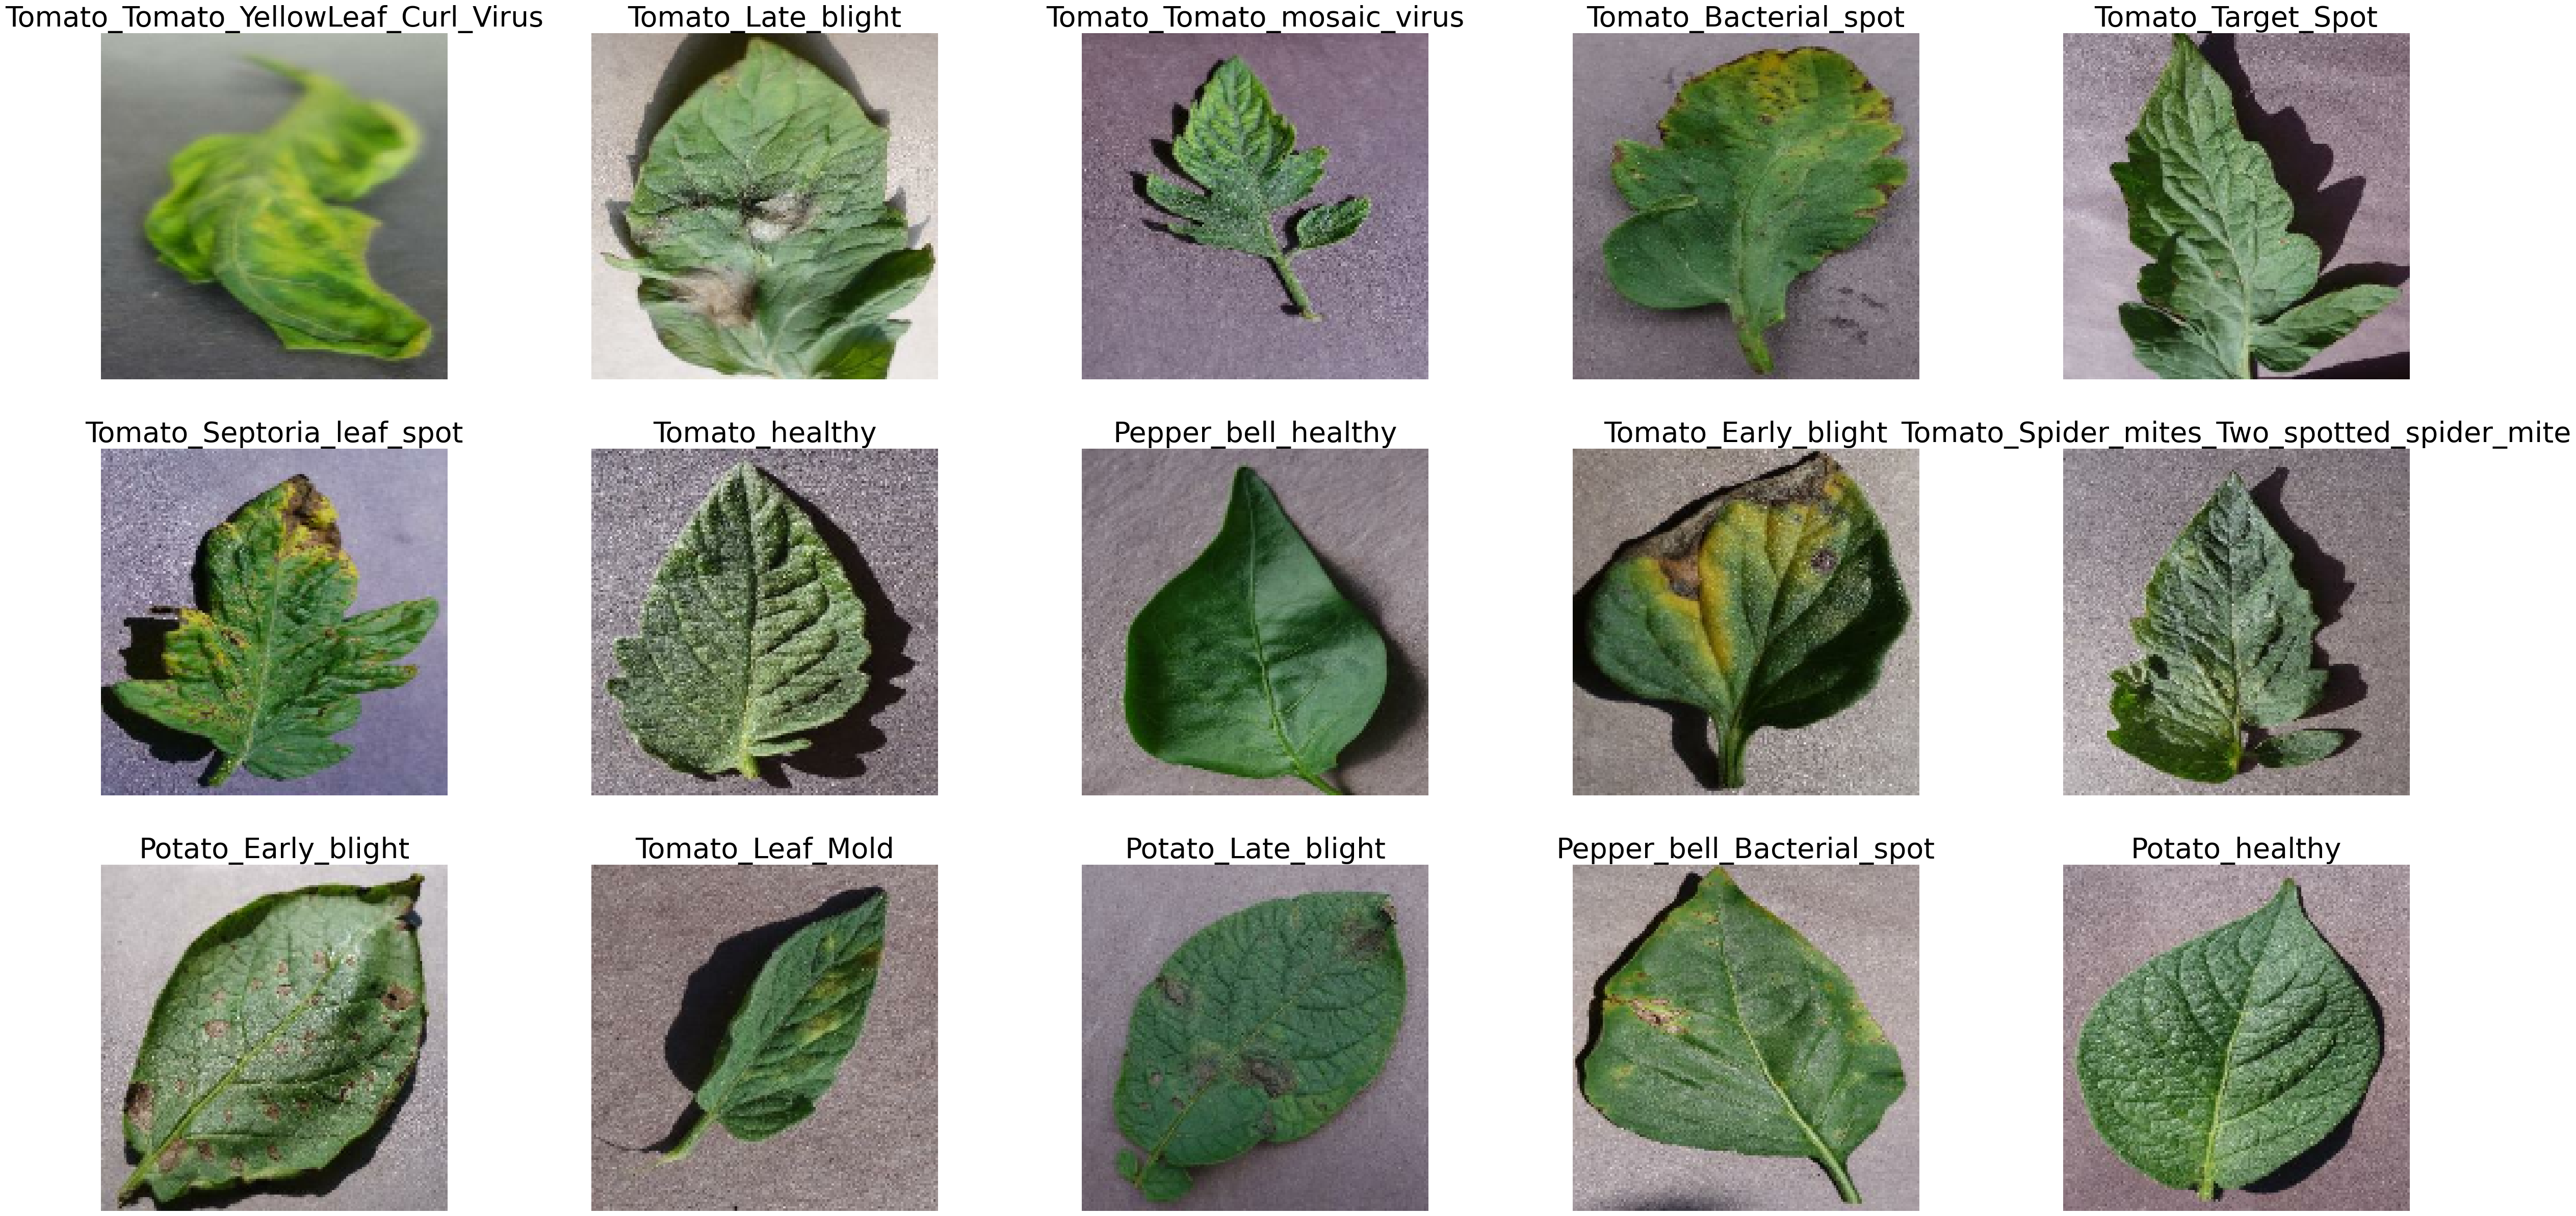

In [248]:
plt.figure(figsize=(60,30))
classes = []
for images, labels in dataset:
    if len(classes)==0:
        print('Shape of one batch and labels:')
        print(images.shape)
    for image, label in zip(images, labels):
        if class_names[label] not in classes:
            ax = plt.subplot(3,5,len(classes)+1)
            plt.imshow(image.numpy().astype(int)) 
            plt.axis('off')
            plt.title(class_names[label], fontsize=40)
            classes.append(class_names[label])
        if len(classes)==15: break
plt.savefig('results/images/all_classes')

In [8]:
train, val, test = utils.dataset_partition(dataset)
print(len(train), len(val), len(test))
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

258 32 33


In [9]:
# Data preprocessing
data_preprocess = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [11]:
# Set up compile
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)
opt_adam = optimizers.Adam(learning_rate=0.01, decay=1e-6)
metric = 'accuracy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#Callback
name = 'plants'
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = CallBacks.checkpoint_call(name)

steps_per_epoch = len(train)
validation_steps = len(val)

input_shape = (batch_size, image_size, image_size, 3)

In [12]:
base_ResNet50, base_ResNet50_output = PreTrain.get_ResNet50(image_size=image_size)

x = Flatten()(base_ResNet50_output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model01 = Model(inputs=base_ResNet50.input, outputs=x)

model01.build(input_shape=input_shape)

model01.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [31]:
model01.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [32]:
hist01_v1 = model01.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 1/20
516/516 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.8310
Epoch 1: val_loss improved from inf to 0.30142, saving model to checkpoints/plants/2\1.ckpt
516/516 [==============================] - 87s 161ms/step - loss: 0.5975 - accuracy: 0.8310 - val_loss: 0.3014 - val_accuracy: 0.9048 - lr: 0.0100
Epoch 2/20
516/516 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9241
Epoch 2: val_loss did not improve from 0.30142
516/516 [==============================] - 77s 149ms/step - loss: 0.2233 - accuracy: 0.9241 - val_loss: 0.3864 - val_accuracy: 0.8872 - lr: 0.0100
Epoch 3/20
516/516 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9490
Epoch 3: val_loss did not improve from 0.30142

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
516/516 [==============================] - 72s 140ms/step - loss: 0.1578 - accuracy: 0.9490 - val_loss: 0.3153 - val_accuracy: 0.9111 - lr: 0.0100
Epoch 4/

In [33]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

In [34]:
hist01_v2 = model01.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist01_v1.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 21/30
516/516 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9999
Epoch 21: val_loss did not improve from 0.13715
516/516 [==============================] - 57s 109ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.1552 - val_accuracy: 0.9614 - lr: 1.0000e-05
Epoch 22/30
516/516 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9999
Epoch 22: val_loss did not improve from 0.13715
516/516 [==============================] - 61s 117ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.1489 - val_accuracy: 0.9604 - lr: 1.0000e-05
Epoch 23/30
516/516 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9999
Epoch 23: val_loss did not improve from 0.13715
516/516 [==============================] - 55s 107ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 0.1475 - val_accuracy: 0.9609 - lr: 1.0000e-05
Epoch 24/30
516/516 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9999
Epoch 24: val_l

Merged successfully!
Save successfully into history\plants\1.pkl


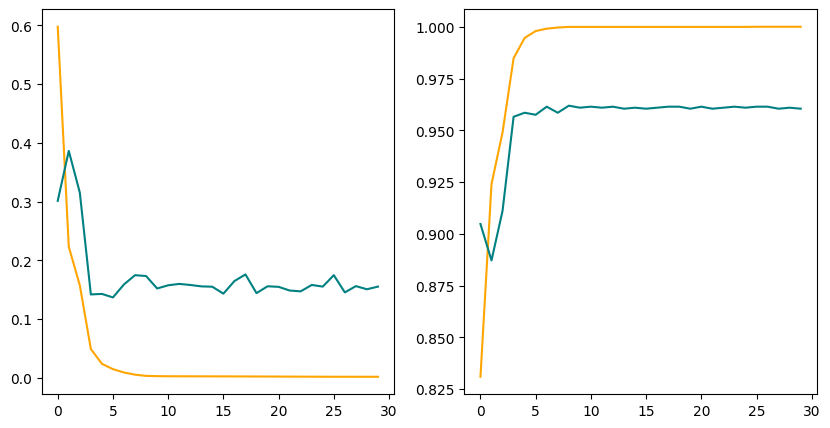

In [43]:
hist01 = History.merge_hist([hist01_v1, hist01_v2])
History.save_hist(hist01, name)
History.plot_loss_metric(hist01)

In [44]:
scores01 = model01.evaluate(test)
scores01

65/65 [==============================] - 17s 120ms/step - loss: 0.2018 - accuracy: 0.9514


[0.2018376737833023, 0.951395571231842]

In [49]:
x = Flatten()(base_ResNet50_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model02 = Model(inputs=base_ResNet50.input, outputs=x)

model02.build(input_shape=input_shape)

model02.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [50]:
opt_adam = optimizers.Adam(learning_rate=0.01, decay=1e-6)
checkpoint_callback = CallBacks.checkpoint_call(name)

model02.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [51]:
hist02_v1 = model02.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 1/10
516/516 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.8465
Epoch 1: val_loss improved from inf to 0.37541, saving model to checkpoints/plants/4\1.ckpt
516/516 [==============================] - 55s 102ms/step - loss: 0.4847 - accuracy: 0.8465 - val_loss: 0.3754 - val_accuracy: 0.8799 - lr: 0.0100
Epoch 2/10
516/516 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9307
Epoch 2: val_loss improved from 0.37541 to 0.23430, saving model to checkpoints/plants/4\2.ckpt
516/516 [==============================] - 52s 101ms/step - loss: 0.2084 - accuracy: 0.9307 - val_loss: 0.2343 - val_accuracy: 0.9189 - lr: 0.0100
Epoch 3/10
516/516 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9511
Epoch 3: val_loss did not improve from 0.23430
516/516 [==============================] - 53s 102ms/step - loss: 0.1402 - accuracy: 0.9511 - val_loss: 0.4972 - val_accuracy: 0.8687 - lr: 0.0100
Epoch 4/10
516/516 [================

In [53]:
hist02_v2 = model02.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist02_v1.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 11/20
516/516 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9999
Epoch 11: val_loss did not improve from 0.13195
516/516 [==============================] - 55s 105ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0.1345 - val_accuracy: 0.9629 - lr: 1.0000e-04
Epoch 12/20
516/516 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9999
Epoch 12: val_loss did not improve from 0.13195
516/516 [==============================] - 51s 100ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.1361 - val_accuracy: 0.9614 - lr: 1.0000e-04
Epoch 13/20
516/516 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 13: val_loss did not improve from 0.13195

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
516/516 [==============================] - 52s 101ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.9614 - lr: 1.0000e-04
Epoch 14/20
516/516 [=============

Merged successfully!
Save successfully into history\plants\2.pkl


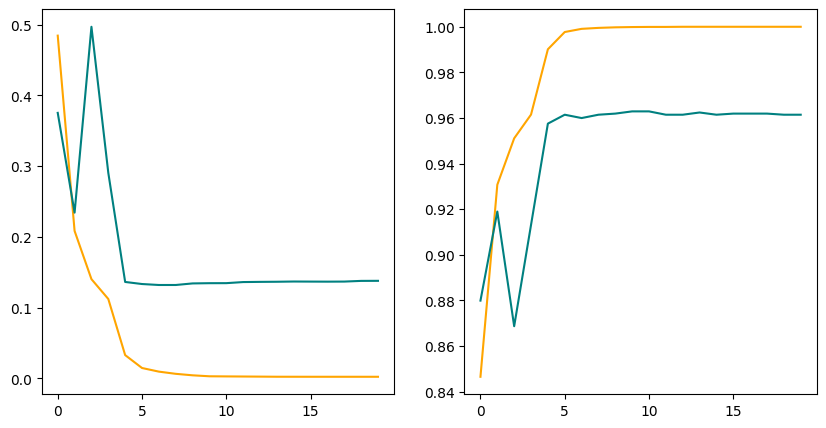

In [54]:
hist02 = History.merge_hist([hist02_v1, hist02_v2])
History.save_hist(hist02, name)
History.plot_loss_metric(hist02)

In [70]:
CallBacks.load_checkpoint(model02, name, '4/7')
scores02 = model02.evaluate(test)
scores02

Loaded:  checkpoints/plants/4/7.ckpt
65/65 [==============================] - 8s 122ms/step - loss: 0.1944 - accuracy: 0.9437


[0.19436423480510712, 0.9436958432197571]

In [57]:
utils.save_model(model02,name)

INFO:tensorflow:Assets written to: models/plants/1\assets


In [63]:
base_ResNet50 = Model(inputs=base_ResNet50.input, outputs=base_ResNet50.layers[-2].output)
base_ResNet50_output = base_ResNet50.layers[-2].output

x = Flatten()(base_ResNet50_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model03 = Model(inputs=base_ResNet50.input, outputs=x)

model03.build(input_shape=input_shape)

model03.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [64]:
opt_adam = optimizers.Adam(learning_rate=0.01, decay=1e-6)
checkpoint_callback = CallBacks.checkpoint_call(name)

model03.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [65]:
hist03_v1 = model03.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 1/10
516/516 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.8344
Epoch 1: val_loss improved from inf to 0.26761, saving model to checkpoints/plants/5\1.ckpt
516/516 [==============================] - 63s 117ms/step - loss: 0.5220 - accuracy: 0.8344 - val_loss: 0.2676 - val_accuracy: 0.9082 - lr: 0.0100
Epoch 2/10
516/516 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9433
Epoch 2: val_loss did not improve from 0.26761
516/516 [==============================] - 55s 107ms/step - loss: 0.1695 - accuracy: 0.9433 - val_loss: 0.2941 - val_accuracy: 0.9058 - lr: 0.0100
Epoch 3/10
516/516 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9664
Epoch 3: val_loss improved from 0.26761 to 0.23552, saving model to checkpoints/plants/5\3.ckpt
516/516 [==============================] - 58s 113ms/step - loss: 0.0939 - accuracy: 0.9664 - val_loss: 0.2355 - val_accuracy: 0.9268 - lr: 0.0100
Epoch 4/10
516/516 [================

In [66]:
hist03_v2 = model03.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch = hist03_v1.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 11/20
516/516 [==============================] - ETA: 0s - loss: 9.5224e-04 - accuracy: 1.0000
Epoch 11: val_loss improved from 0.15979 to 0.15939, saving model to checkpoints/plants/5\11.ckpt
516/516 [==============================] - 59s 114ms/step - loss: 9.5224e-04 - accuracy: 1.0000 - val_loss: 0.1594 - val_accuracy: 0.9570 - lr: 1.0000e-03
Epoch 12/20
516/516 [==============================] - ETA: 0s - loss: 6.9455e-04 - accuracy: 1.0000
Epoch 12: val_loss improved from 0.15939 to 0.15837, saving model to checkpoints/plants/5\12.ckpt
516/516 [==============================] - 57s 110ms/step - loss: 6.9455e-04 - accuracy: 1.0000 - val_loss: 0.1584 - val_accuracy: 0.9580 - lr: 1.0000e-03
Epoch 13/20
516/516 [==============================] - ETA: 0s - loss: 5.2414e-04 - accuracy: 1.0000
Epoch 13: val_loss improved from 0.15837 to 0.15759, saving model to checkpoints/plants/5\13.ckpt
516/516 [==============================] - 53s 103ms/step - loss: 5.2414e-04 - accuracy: 1.00

In [67]:
hist03_v3 = model03.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch = hist03_v2.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 21/30
516/516 [==============================] - ETA: 0s - loss: 2.1395e-04 - accuracy: 1.0000
Epoch 21: val_loss did not improve from 0.15759
516/516 [==============================] - 58s 111ms/step - loss: 2.1395e-04 - accuracy: 1.0000 - val_loss: 0.1636 - val_accuracy: 0.9604 - lr: 1.0000e-06
Epoch 22/30
516/516 [==============================] - ETA: 0s - loss: 2.1374e-04 - accuracy: 1.0000
Epoch 22: val_loss did not improve from 0.15759
516/516 [==============================] - 57s 111ms/step - loss: 2.1374e-04 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9604 - lr: 1.0000e-06
Epoch 23/30
516/516 [==============================] - ETA: 0s - loss: 2.1346e-04 - accuracy: 1.0000
Epoch 23: val_loss did not improve from 0.15759
516/516 [==============================] - 58s 112ms/step - loss: 2.1346e-04 - accuracy: 1.0000 - val_loss: 0.1633 - val_accuracy: 0.9609 - lr: 1.0000e-06
Epoch 24/30
516/516 [==============================] - ETA: 0s - loss: 2.1314e-04 - accu

Merged successfully!
Save successfully into history\plants\4.pkl


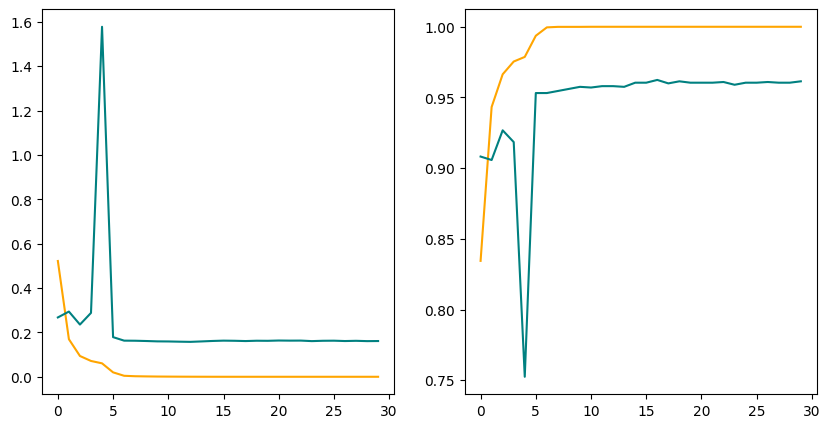

In [75]:
hist03 = History.merge_hist([hist03_v1, hist03_v2, hist03_v3])
History.save_hist(hist03,name)
History.plot_loss_metric(hist03)

In [73]:
utils.save_model(model03,name)

INFO:tensorflow:Assets written to: models/plants/2\assets


In [22]:
base_ResNet101, base_ResNet101_output = PreTrain.get_ResNet101(image_size=image_size)

In [23]:
x = Flatten()(base_ResNet101_output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model04 = Model(inputs=base_ResNet101.input, outputs=x)

model04.build(input_shape=input_shape)

model04.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [24]:
opt_adam = optimizers.Adam(learning_rate=0.01, decay=1e-6)
checkpoint_callback = CallBacks.checkpoint_call(name)

model04.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [15]:
hist04_v1 = model04.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 1/10
258/258 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8375
Epoch 1: val_loss improved from inf to 0.33182, saving model to checkpoints/plants/6\1.ckpt
258/258 [==============================] - 111s 295ms/step - loss: 0.5608 - accuracy: 0.8375 - val_loss: 0.3318 - val_accuracy: 0.8887 - lr: 0.0100
Epoch 2/10
258/258 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9384
Epoch 2: val_loss did not improve from 0.33182
258/258 [==============================] - 60s 231ms/step - loss: 0.1884 - accuracy: 0.9384 - val_loss: 0.4477 - val_accuracy: 0.8794 - lr: 0.0100
Epoch 3/10
258/258 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9495
Epoch 3: val_loss did not improve from 0.33182

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
258/258 [==============================] - 62s 240ms/step - loss: 0.1516 - accuracy: 0.9495 - val_loss: 0.4318 - val_accuracy: 0.8877 - lr: 0.0100
Epoch 4

In [16]:
hist04_v2 = model04.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist04_v1.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 11/20
258/258 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9999
Epoch 11: val_loss did not improve from 0.14299
258/258 [==============================] - 66s 254ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 0.1458 - val_accuracy: 0.9609 - lr: 1.0000e-05
Epoch 12/20
258/258 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9999
Epoch 12: val_loss did not improve from 0.14299
258/258 [==============================] - 63s 244ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 0.1459 - val_accuracy: 0.9619 - lr: 1.0000e-05
Epoch 13/20
258/258 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9999
Epoch 13: val_loss did not improve from 0.14299
258/258 [==============================] - 67s 258ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 0.1461 - val_accuracy: 0.9614 - lr: 1.0000e-05
Epoch 14/20
258/258 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9999
Epoch 14: val_l

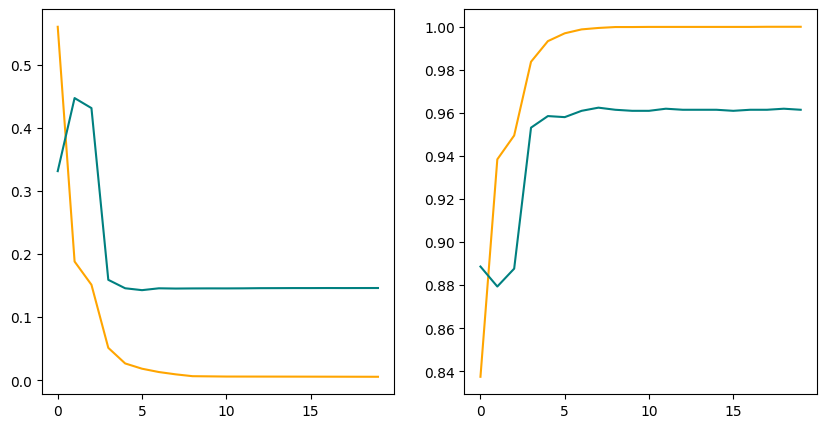

In [30]:
hist04 = History.merge_hist([hist04_v1, hist04_v2])
History.save_hist(hist04,name)
History.plot_loss_metric(hist04)

In [25]:
CallBacks.load_checkpoint(model04,name,'6/6')
scores04 = model04.evaluate(test)
scores04

Loaded:  checkpoints/plants/6/6.ckpt
33/33 [==============================] - 9s 169ms/step - loss: 0.0444 - accuracy: 0.9885


[0.04440879821777344, 0.9884504079818726]

c:\Users\USER\Music\PROGRAMING\Projects\230721-potato-disease\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Precision:
0.9872424115845169
Average Recall:
0.9870379072681704
F1 Score:
0.9871401488346322
Confusion Matrix:
[[101   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 138   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 110   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 101   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0  16   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 219   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1  93   0   0   0   2   1   1   0   0]
 [  0   0   0   0   0   0   3 159   1   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0  92   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 174   0   1   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0 165   3   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 150   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 338   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  37   0

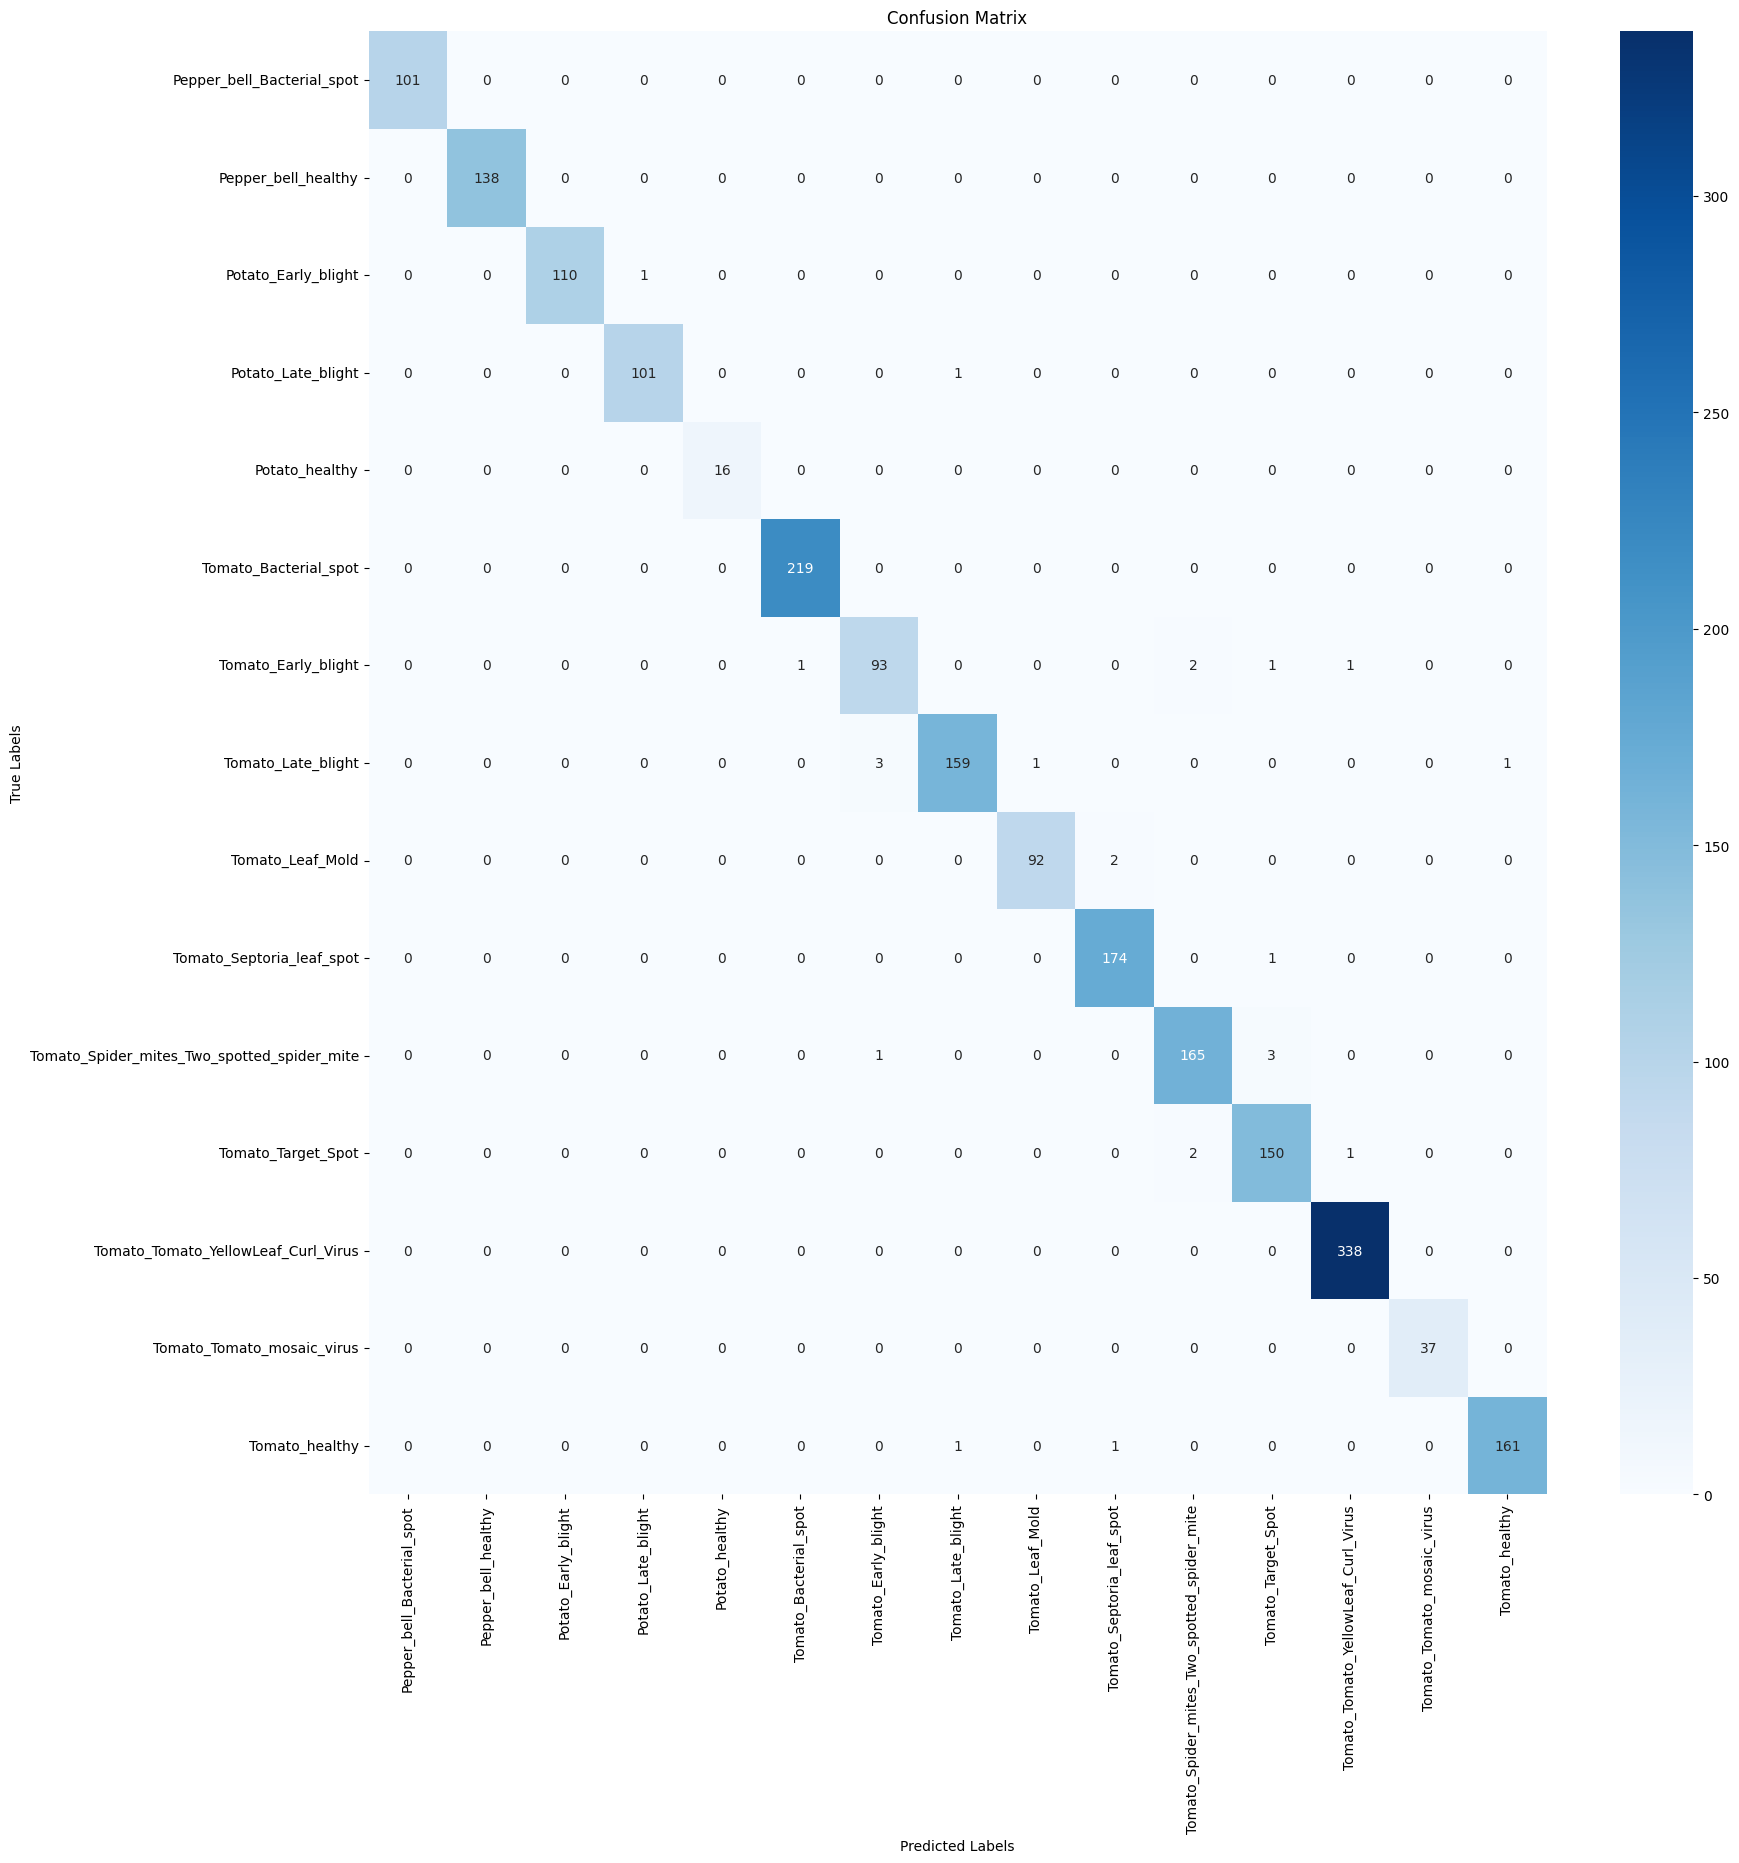

In [26]:
_, _, _, cf_heatmap_model04 = utils.precision_recall(model04, test)
utils.confusion_heatmap(cf_heatmap_model04, class_names)

In [20]:
base_ResNet101 = Model(inputs=base_ResNet101.inputs, outputs=base_ResNet101.layers[-2].output)
base_ResNet101_output = base_ResNet101.layers[-2].output

x = Flatten()(base_ResNet101_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model05 = Model(inputs=base_ResNet101.input, outputs=x)

model05.build(input_shape=input_shape)

model05.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [21]:
opt_adam = optimizers.Adam(learning_rate=0.01, decay=1e-6)
checkpoint_callback = CallBacks.checkpoint_call(name)

model05.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [35]:
hist05_v1 = model05.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 1/10
258/258 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.7656
Epoch 1: val_loss improved from inf to 1.56904, saving model to checkpoints/plants/7\1.ckpt
258/258 [==============================] - 81s 297ms/step - loss: 0.7240 - accuracy: 0.7656 - val_loss: 1.5690 - val_accuracy: 0.6309 - lr: 0.0100
Epoch 2/10
258/258 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8864
Epoch 2: val_loss improved from 1.56904 to 0.43649, saving model to checkpoints/plants/7\2.ckpt
258/258 [==============================] - 71s 274ms/step - loss: 0.3450 - accuracy: 0.8864 - val_loss: 0.4365 - val_accuracy: 0.8589 - lr: 0.0100
Epoch 3/10
258/258 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9313
Epoch 3: val_loss did not improve from 0.43649
258/258 [==============================] - 64s 246ms/step - loss: 0.2110 - accuracy: 0.9313 - val_loss: 0.5120 - val_accuracy: 0.8584 - lr: 0.0100
Epoch 4/10
258/258 [================

In [36]:
hist05_v2 = model05.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist05_v1.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_reducer]
)

Epoch 11/20
258/258 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9996
Epoch 11: val_loss did not improve from 0.24897
258/258 [==============================] - 68s 259ms/step - loss: 0.0104 - accuracy: 0.9996 - val_loss: 0.2582 - val_accuracy: 0.9307 - lr: 1.0000e-04
Epoch 12/20
258/258 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9995
Epoch 12: val_loss did not improve from 0.24897
258/258 [==============================] - 65s 253ms/step - loss: 0.0101 - accuracy: 0.9995 - val_loss: 0.2584 - val_accuracy: 0.9321 - lr: 1.0000e-04
Epoch 13/20
258/258 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9996
Epoch 13: val_loss did not improve from 0.24897

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
258/258 [==============================] - 69s 267ms/step - loss: 0.0098 - accuracy: 0.9996 - val_loss: 0.2597 - val_accuracy: 0.9316 - lr: 1.0000e-04
Epoch 14/20
258/258 [=============

Merged successfully!
Save successfully into history\plants\9.pkl


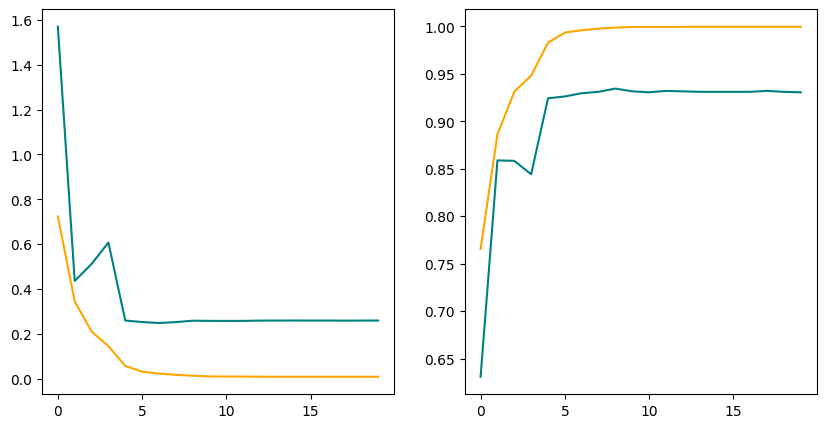

In [59]:
hist05 = History.merge_hist([hist05_v1, hist05_v2])
History.save_hist(hist05,name)
History.plot_loss_metric(hist05)

In [23]:
CallBacks.load_checkpoint(model05,name,'7/7')
scores05 = model05.evaluate(test)
scores05

Loaded:  checkpoints/plants/7/7.ckpt
33/33 [==============================] - 9s 231ms/step - loss: 23.6830 - accuracy: 0.8244


[23.683000564575195, 0.8243503570556641]

In [13]:
model03 = utils.load_model(folder_name=name)

Successfully load model: plants/2


In [120]:
model = tf.keras.Sequential()
model.add(data_preprocess)
model.add(model03)
model.build(input_shape=(None, 150, 150, 3))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 model_8 (Functional)        (None, 15)                49812367  
                                                                 
Total params: 49,812,367
Trainable params: 26,223,631
Non-trainable params: 23,588,736
_________________________________________________________________


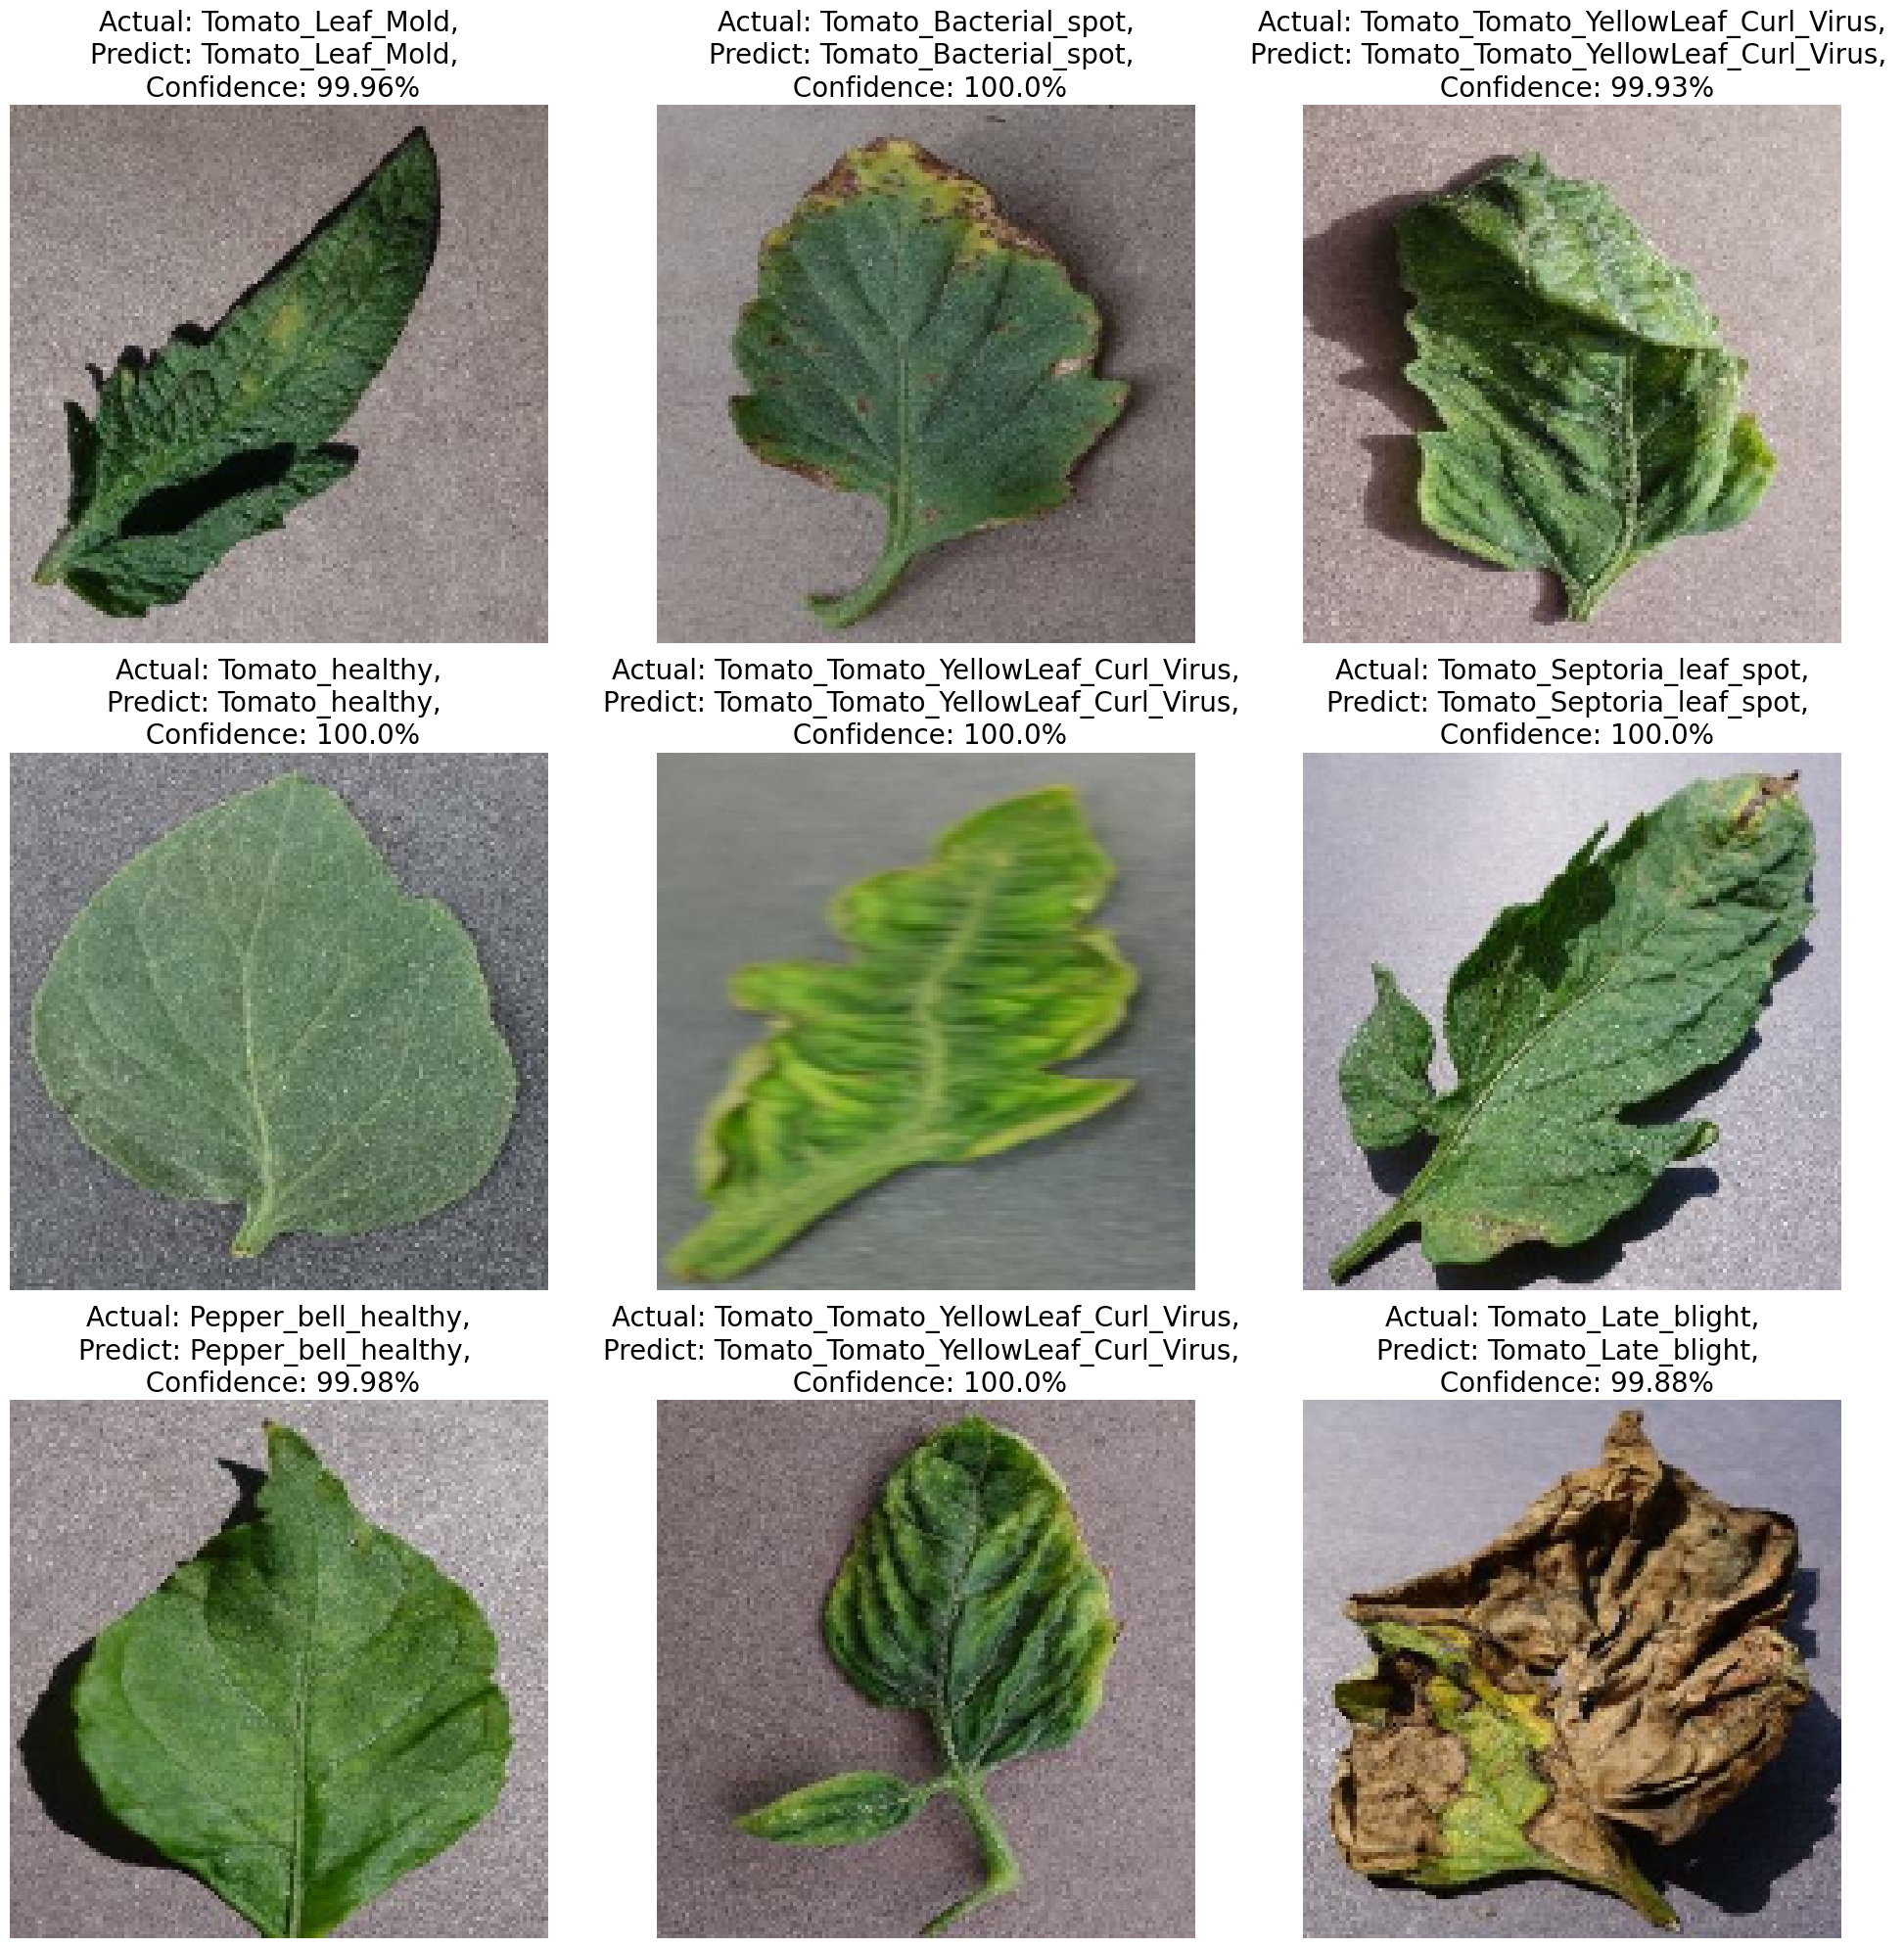

In [243]:
is_break = False
while not is_break:
    for images, labels in test.take(1):
        num_img = 9
        if len(images)>=num_img:
            is_break = True
            fig = plt.figure(figsize=(20,20))
            for i in range(num_img):
                ax = plt.subplot(3,3,i+1)
                predict_label, confidence = utils.predict(model03, images[i], class_names)
                actual_label = class_names[labels[i]]
                plt.imshow(images[i].numpy().astype(int))
                plt.title(f'Actual: {actual_label},\nPredict: {predict_label}, \n Confidence: {confidence}%', fontsize=20)
                plt.axis('off')
            fig.tight_layout()
            plt.savefig('results/images/predictions.png')

In [162]:
path = "data/data2/Tomato_Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG"

def resize_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.LANCZOS)
    img = np.expand_dims(np.array(img),0)
    return img

img = resize_image(path)

In [165]:
prediction = model03.predict(img)
class_names[np.argmax(prediction)]

'Tomato_Bacterial_spot'

In [119]:
scores = model03.evaluate(test)
scores

33/33 [==============================] - 8s 154ms/step - loss: 0.0296 - accuracy: 0.9937


[0.029583344236016273, 0.9937439560890198]

Average Precision:
0.9924577124795942
Average Recall:
0.9920773852940153
Average F1 Score:
0.9922675124428113
Confusion Matrix:
[[109   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 151   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 105   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 101   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  13   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 213   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  98   3   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   1 183   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  90   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 168   1   0   0   1   0]
 [  0   0   0   0   0   0   1   0   0   0 173   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   2 138   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 310   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0

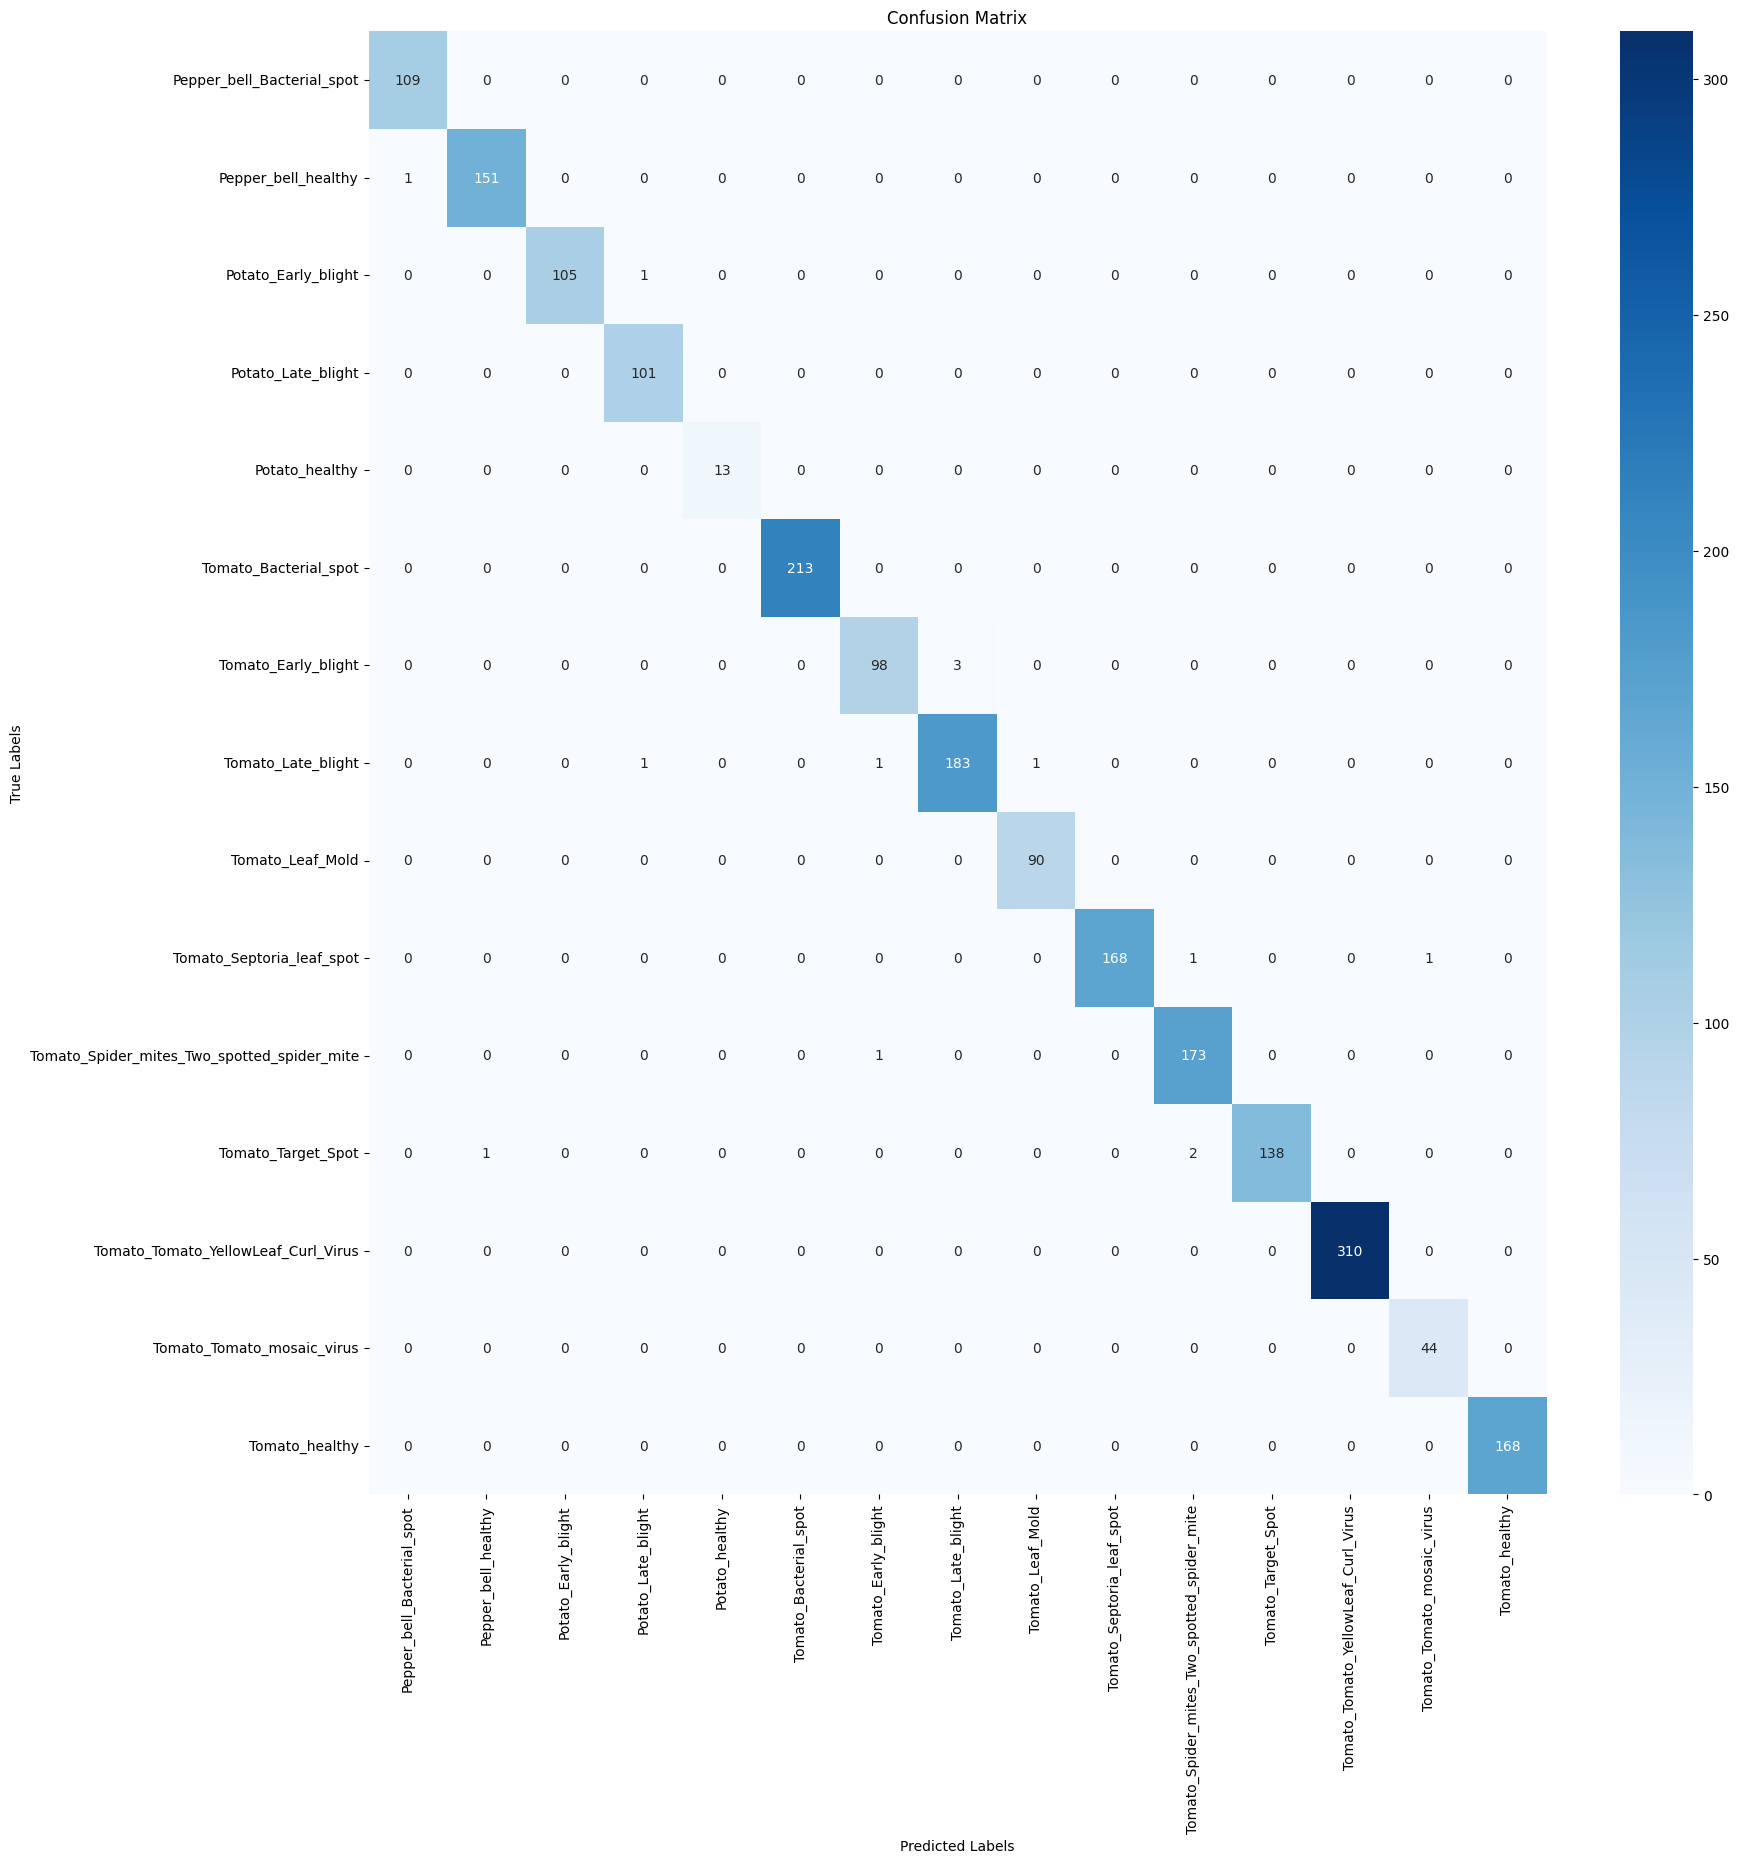

In [19]:
precision, recall, f1_score, cf_matrix = utils.precision_recall(model03, test)
utils.confusion_heatmap(cf_matrix, class_names, save='results/images/cf_map.png')

In [246]:
np.save(os.path.join('results/metrics/', 'precision.npy'), precision)
np.save(os.path.join('results/metrics/', 'recall.npy'), recall)
np.save(os.path.join('results/metrics/', 'f1_scores.npy'), f1_score)

In [204]:
avg_test_time = utils.evaluate_time(model03, test, is_return=True)

Testing time:  2.751253566797016 ms/sample


In [27]:
utils.evaluate_time(model04, test)

Testing time:  4.028591774655031 ms/sample


In [209]:
y_scores = []
y_true = []
for images, labels in test:
    y_scores.append(model03.predict(images))
    y_true = np.concatenate([y_true, labels.numpy()], axis=0)
y_scores = np.vstack(y_scores)

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(class_names)

avg_auc_roc = roc_auc_score(y_true, y_scores, multi_class='ovr', average='weighted')
print(avg_auc_roc)

0.9997049779138053


In [225]:
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

In [232]:
from tabulate import tabulate

# Create a summary table
data = [
    ['Precision', avg_precision],
    ['Recall', avg_recall],
    ['F1-Score', avg_f1_score],
    ['AUC-ROC', avg_auc_roc],
    ['Test Time (ms/sample)', avg_test_time*1000]
]

table = tabulate(data, headers=['Metric', 'Value'], tablefmt='plain', colalign=("left", "right"))

# Print the summary table
print(table)


Metric                    Value
Precision              0.989004
Recall                 0.987876
F1-Score               0.983069
AUC-ROC                0.999705
Test Time (ms/sample)   2.75125
